In [8]:
import numpy as np
import matplotlib

# Embed fonts into PDF/PS files
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.colors

import scipy.integrate
import scipy.optimize

In [9]:
matplotlib.rcParams.update({'font.size': 7, 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'xtick.minor.width': 0.5, 
                            'ytick.major.width': 0.5,'ytick.minor.width': 0.5, 'xtick.major.pad':2,'ytick.major.pad':2})
matplotlib.rcParams.update({'font.family':'sans-serif','font.sans-serif':['Arial']})

In [10]:
def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2
            for (c1, c2) in zip(rgb, bg_rgb)]

# Define parameters

In [29]:
## Physiological parameters

# mvn head sensitvity in the light: 0.38 sp/s / deg/s for ~0.85 gain -- Beraneck & Cullen 2007
# => k_eye ~= 2.2

# initial gain ~- 0.4 in mice (Katoh et al. 2015, Boyden & Raymond 2003)
# => v_0 = 1.3

# Hannah opto stim experiment
# ~0.1 deg/s / sp/s = k_eye * w_PC => w_PC ~= 0.05

# average learning in one day ~20-40% (Kimpo et al. 2014, Boyden & Raymond 2003)
# delta w ~= delta g/g_0 * v_0*k_MF / w_pc_mvn*k_PF
# delta g/g_0 ~= 0.3 = > delta w ~= 2.6
# => for ~50% decrease during training (Jang, Shim et al. 2020), set w_i = 5

# memory retention ~75% after 24 hr calculated from Boyden & Raymond 2003

params = {
    'mf_0': 55, # Lasker et al. 2008
    'pf_0': 14, # Arenz et al. 2008 -- assume each MF EPSC evokes a GC spike
    'cf_0': 1,
    'mf_sensitivity': 0.14, # Lasker et al. 2008
    'k_pf_h': 0.42, # Arenz et al. 2008 (See above)
    'w_inh_h': 5,
    'pc_0':50, # Katoh et al. 2015  
    'w_pc_mvn': 0.05, #0.5
    'k_eye': 2.2,
    'k_v': 8e-3, # 2.5 0.01 # to get 75% retention
    'tau_f': 0.017, # fast average
    'tau_mvn': 0.7, # tau_f,v: average of activity being integrated at MVN
    'tau_learn': 0.15, # Boyden & Raymond 2003
    'tau_post': 5, # calculated from Jang, Shim et al. 2020
    'k_LTD': 0.648, 
    'beta_rs': 1, # Guo et al. 2014
    'tau_theta':0.0395, # 1
}
params['k_LTP'] = params['w_inh_h']/params['pf_0'] + params['k_LTD']*params['cf_0']
# so that w(t -> infty) = 0 => w^+(infty) = w^-

## Behavioral parameters

# Kimpo et al. 2014, Nguyen-Vu et al. 2013, Boyden & Raymond 2003
stim_freq = 1 
peak_velocity_learn = 15 # deg/s
peak_velocity_post = 15

# Define function for head velocity
head_learn = lambda t: peak_velocity_learn*np.sin(2*np.pi*stim_freq*3600*t)
head_post_input = lambda t: peak_velocity_post*np.sin(2*np.pi*stim_freq*3600*t) # w/post-training input
head_post_no_input = lambda t: 0 # w/o post-training input

# Define function for retinal slip
target_learn = lambda t: -peak_velocity_learn*np.sin(2*np.pi*stim_freq*3600*t)
target_post = lambda t: 0

In [47]:
params['k_LTP']

1.0051428571428571

In [12]:
gain = lambda w, v: params['k_eye']*((params['mf_sensitivity']*v - 
                                    params['k_pf_h']*params['w_pc_mvn']*w))
    

In [43]:
# initial gain ~- 0.4 in mice (Katoh et al. 2015, Boyden & Raymond 2003)
g_init = 0.4
v_0_ = lambda g_init: g_init/(params['k_eye']*params['mf_sensitivity'])

v_0 = v_0_(g_init)

In [44]:
# Spontaneous firing rate of MVNs is ~57 sp/s (Nelson et al. 2003)

# Calculate MVN offset so that this is the firing rate at baseline
params['mvn_0'] = 57 - params['mf_0']*v_0_(g_init) + params['w_pc_mvn']*50

# ODE Solver

The state `y` has components the following components: `y[0]` is $w$, `y[1]` is $v$, `y[2]` is $\langle\text{MF}(\text{MVN}-\theta)\rangle_{\tau_{f,v}}$, `y[3]` is $\theta = \langle\text{MVN}\rangle_{\tau_{\theta}}$, `y[4]` is $\langle\text{PF}\rangle_{\tau_f}$, and `y[5]` is $\langle\text{PF}\cdot\text{CF}\rangle_{\tau_f}$

In [22]:
# Function to pass to ODE solver
def hebbian(t, y, head, target, learn, params, decay_rate=0):
    '''
    head: a function taking a time argument that returns the head velocity
    target: a function taking a time argument that returns the velocity of the visual target
    learn: set to True if in the training period, False if in the post-training period
    params: list containing the physiological parameters
    decay_rate: defines a decay of the weight v (see SI Text, S.1)
    '''
    
    w = y[0]
    v = y[1]
    
    g = params['k_eye']*(params['mf_sensitivity']*v - 
                         params['k_pf_h']*params['w_pc_mvn']*(w-params['w_inh_h']))
    retinal_slip = target(t) - (1-g)*head(t)
    
    delta_mf = params['mf_sensitivity']*head(t)
    delta_pf = params['k_pf_h']*head(t)
    delta_cf = np.tanh(-params['beta_rs']*retinal_slip)*learn
    
    if learn:
        tau_w = params['tau_learn']
    else:
        tau_w = params['tau_post']
        
    mf = params['mf_0'] + delta_mf
    pf = params['pf_0'] + delta_pf
    cf = params['cf_0'] + delta_cf
    
    delta_pc = (w - params['w_inh_h'])*pf
    pc = delta_pc + params['pc_0']
    mvn = v*mf - params['w_pc_mvn']*pc + params['mvn_0']
    
    dydt = np.zeros(6)
    # w, v, <MF(MVN - <MVN>)>, <MVN>, <PF>, <PF*CF>
    dydt[0] = 1/tau_w * (-y[0] + params['k_LTP']*y[4] - params['k_LTD']*y[5])
    dydt[1] = params['k_v']*(-decay_rate*y[1] + y[2])
    dydt[2] = 1/params['tau_mvn'] * (-y[2] + mf*(mvn - y[3]))
    dydt[3] = 1/params['tau_theta'] * (-y[3]+ mvn)
    dydt[4] = 1/params['tau_f'] * (-y[4] + pf)
    dydt[5] = 1/params['tau_f'] * (-y[5] + pf*cf)
    return dydt

# Jacobian
def hebbianJac(t, y, head, target, learn, params, decay_rate=0):
    w = y[0]
    v = y[1]
    
    g = params['k_eye']*(params['mf_sensitivity']*v - 
                         params['k_pf_h']*params['w_pc_mvn']*(w-params['w_inh_h']))
    retinal_slip = target(t) - (1-g)*head(t)
    
    delta_mf = params['mf_sensitivity']*head(t)
    delta_pf = params['k_pf_h']*head(t)
    delta_cf = np.tanh(-params['beta_rs']*retinal_slip)*learn
    
    if learn:
        tau_w = params['tau_learn']
    else:
        tau_w = params['tau_post']
    mf = params['mf_0'] + delta_mf
    pf = params['pf_0'] + delta_pf
    
    jac = -1/params['tau_f']*np.eye(6)
    jac[0,:] = 1/tau_w*np.array([-1, 0, 0, 0, params['k_LTP'], -params['k_LTD']])
    jac[1,:] = params['k_v']*np.array([0, -decay_rate, 1, 0, 0, 0])
    jac[2,:] = 1/params['tau_mvn']*np.array([-params['w_pc_mvn']*pf*mf, mf**2,-1, -mf, 0,0])
    jac[3,:] = 1/params['tau_theta']*np.array([-params['w_pc_mvn']*pf,mf,0,-1,0,0])
    jac[5,:2] = 1/params['tau_f']*(params['beta_rs']*params['k_eye']*pf*head(t)*(1-delta_cf**2)
                                  *np.array([params['w_pc_mvn']*params['k_pf_h'],
                                              -params['mf_sensitivity']]))
    
    return jac

# Figure 5

## Run simulation

In [23]:
## Time steps for plotting (ODE solver uses variable time steps)

dt_learn = 1/3600 # h (= 1 s)
dt_post = 60/3600 # h (= 1 min)

In [24]:
sigma2_post = 0.5*peak_velocity_post**2

Calculating the eigenvalues and time constants of the idealized dynamics (SI text, S.1):

In [35]:
tau_v_1 = lambda s: 1/(params['k_v']*(params['mf_0']**2 + params['mf_sensitivity']**2*s))
lambda_p = lambda s: (1/tau_v_1(s) - 1/params['tau_theta'])*0.5*(1+
                      np.sqrt(1+(4*params['k_v']*params['mf_sensitivity']**2*s)/(params['tau_theta']*
                     (1/tau_v_1(s)-1/params['tau_theta'])**2)))
lambda_m = lambda s: (1/tau_v_1(s) - 1/params['tau_theta'])*0.5*(1-
                      np.sqrt(1+(4*params['k_v']*params['mf_sensitivity']**2*s)/(params['tau_theta']*
                     (1/tau_v_1(s)-1/params['tau_theta'])**2)))
1/lambda_p(sigma2_post), 1/lambda_m(sigma2_post)

(-0.706950063866226, 3.1674500638662275)

Thus, for the post-training input signal we use here, the value of $v$ undergoes exponential growth with a time constant of ~3.17 h

In [30]:
T_learn = 0.5 # h

T_post = 24 #  - T_learn # s

t_learn = np.linspace(0, T_learn, int(T_learn/dt_learn))
t_post = np.linspace(0, T_post-T_learn, int(T_post/dt_post)) + T_learn

# Initial condition
# v(t=0) was calculated based on parameters above
v_0 = 1.3

# Initial value for theta:
mvn_0 = v_0*params['mf_0'] - params['w_pc_mvn']*params['pc_0'] + params['mvn_0']
y_0 = np.array([params['w_inh_h'], v_0, 0,mvn_0, params['pf_0'], params['pf_0']*params['cf_0']])

# Solution during the training period
sol_learn = scipy.integrate.solve_ivp(lambda t,y: hebbian(t,y, head_learn, target_learn, True, params), [0, T_learn], y_0, 
                                  jac=lambda t,y: hebbianJac(t,y,head_learn, target_learn,True,params), method='Radau', max_step=1/3600*0.5, dense_output=True)

# Solution during the post-training period w/o input
sol_no_input_post = scipy.integrate.solve_ivp(lambda t,y: hebbian(t,y, head_post_no_input, target_post, False, params), [T_learn, T_post],sol_learn.sol(T_learn),
                                  jac=lambda t,y: hebbianJac(t,y,head_post_no_input, target_post, False, params), method='Radau',dense_output=True)

# Solution during the post-training period w/input
sol_input_post = scipy.integrate.solve_ivp(lambda t,y: hebbian(t,y, head_post_input, target_post, False, params), [T_learn,T_post],sol_learn.sol(T_learn),
                                  jac=lambda t,y: hebbianJac(t,y,head_post_input, target_post, False, params), method='Radau',max_step=1/3600*0.5, dense_output=True)


# Concatenate solution vectors over time

y_learn = sol_learn.sol(t_learn)

y_no_input = np.hstack((y_learn, sol_no_input_post.sol(t_post)))
y_input = np.hstack((y_learn, sol_input_post.sol(t_post)))

t_sol = np.concatenate((t_learn, t_post))

## Figure 5A

In [17]:
r70 = make_rgb_transparent(matplotlib.colors.to_rgb('C3'), [1,1,1], 0.3)

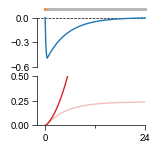

In [39]:
plt.figure(figsize=(1.4,1.4))

ax = plt.subplot(2,1,1)

plt.plot([-2,24], [0,0],'k--',lw=0.5)

plt.plot([0, 0.5],[0.1,]*2,  c='C1', lw=2, clip_on=False)
plt.plot([0.5, 24], [0.1,]*2,  c=(0.7,)*3, lw=2, clip_on=False)

plt.plot(t_sol, (y_no_input[0,:]-params['w_inh_h'])/y_no_input[0,0], clip_on=False,lw=1)
plt.ylim([-0.6, 0])
plt.xlim([-2,24])
ax.xaxis.set_visible(False)

ax.set_yticks([0, -0.3, -0.6])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax = plt.subplot(2,1,2)
plt.plot(t_sol, (y_no_input[1,:]-y_no_input[1,0])/y_no_input[1,0], c=r70,lw=1)
plt.plot(t_sol, (y_input[1,:]-y_input[1,0])/y_input[1,0],c='C3',lw=1)

plt.ylim([0, 0.5])
plt.xlim([-2,24])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([0, 0.25,0.5])

ax.set_xticks([0,12,24])
ax.set_xticks([0, 24])
ax.set_xticks([12], minor=True)

## Figure 5B

In [38]:
gain_no_input = gain(y_no_input[0,:]-params['w_inh_h'], y_no_input[1,:])
gain_input = gain(y_input[0,:]-params['w_inh_h'], y_input[1,:])

In [33]:
gain_no_input_v = gain(0, y_no_input[1,:])
gain_input_v = gain(0, y_input[1,:])

In [41]:
gain_learn = gain(y_learn[0,-1]-params['w_inh_h'], y_learn[1,-1])

In [46]:
(gain_no_input[-1] - g_init)/(gain_learn - g_init)

0.8026309796600164

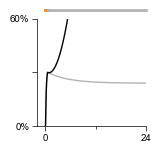

In [40]:
plt.figure(figsize=(1.4,1.4))
# plt.plot([-2,24], [0,0],'k--',lw=0.75)

plt.plot([0, 0.5],[0.65,]*2,  c='C1', lw=2, clip_on=False)
plt.plot([0.5, 24], [0.65,]*2,  c=(0.7,)*3, lw=2, clip_on=False)

plt.plot(t_sol, (gain_no_input - gain_no_input[0])/gain_no_input[0], c=(0.7,)*3,lw=1)
plt.plot(t_sol, (gain_input - gain_input[0])/gain_input[0], c='k',lw=1)
# plt.plot(t_sol, (gain_less - gain_less[0])/gain_less[0], c=(0.66,)*3)
plt.ylim([0, 0.6])
plt.xlim([-2,24])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks([0, 0.3, 0.6])
ax.set_yticklabels(['0%','','60%'])

ax.set_xticks([0,12,24])
ax.set_xticks([0, 24])
ax.set_xticks([12], minor=True)